CS 289A Homework 4
==================
Start with program overhead: load modules (and reload them as they are modified)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import HW04_utils as ut
import numpy as np
from scipy import special as spsp
from matplotlib import pyplot as plt

Next, we give a couple paths specifying where to find the data set on the local machine. **A user must change this to reflect the path to their data.**

In [4]:
BASE_DIR = "/Users/mitch/Documents/Cal/2_2017_Spring/COMPSCI 289A - Intro to Machine Learning/HW04"
DATA_PATH = "Data/data.mat"

Then, load the data using the custom utilities module:

In [5]:
# Load training data
descriptions = ut.loaddata(DATA_PATH,BASE_DIR,'description')
X = ut.loaddata(DATA_PATH,BASE_DIR,'X')
y = ut.loaddata(DATA_PATH,BASE_DIR,'y')

# Shuffle training data
data = np.concatenate((X,y),axis=1)
np.random.shuffle(data)
X = data[:,:-1]
y = data[:,-1]

# Normalize training data
meanX = np.tile(np.mean(X,axis=0),(len(X),1))
minX = np.tile(np.amin(X,axis=0),(len(X),1))
maxX = np.tile(np.amax(X,axis=0),(len(X),1))
X = (X-meanX)/(maxX-minX)

# Separate a validation set that is a given fraction of the training data
frac = 1/6
n = int(len(X)-frac*len(X))
X_train = X[:n]
X_val = X[n:]
y_train = y[:n]
y_val = y[n:]

X = X_train
y = y_train

# Load test data
X_test = ut.loaddata(DATA_PATH,BASE_DIR,'X_test')

# Normalize test data
meanXt = np.tile(np.mean(X_test,axis=0),(len(X_test),1))
minXt = np.tile(np.amin(X_test,axis=0),(len(X_test),1))
maxXt = np.tile(np.amax(X_test,axis=0),(len(X_test),1))
X_test = (X_test-meanXt)/(maxXt-minXt)

Part 1
-------
We use the following procedure to find the optimal $w$ using batch gradient descent:

(1)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w \leftarrow$ arbitrary starting point  
(2)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; while $J(w) > 0$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$w \leftarrow w - \epsilon(2 \lambda w - X^T(y-s))$  
(3)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; return $w$

Step (1)

In [6]:
w = np.zeros(len(descriptions))

Step (2)

In [7]:
def update_w_batch(w,X,y,lam,eps):
    s = spsp.expit(np.dot(X,w))
    w_prime = w - eps*(2*lam*w-np.dot(X.T,(y-s)))
    
    return w_prime

In [8]:
def costfnJ(w,X,y,lam):
    s = spsp.expit(np.dot(X,w))
    J = lam*np.linalg.norm(w)**2 - np.sum(y*np.log(s) + (np.ones_like(y)-y)*np.log(np.ones_like(s)-s))

    return J

In [9]:
def whileloop(w,X,y,lam,eps,tol,update_fn):
    i=0
    iters,Js = [],[]
    J = costfnJ(w,X,y,lam)
    lastJ = J+1  #dummy condition to pass while condition on first run
    while J>0 and i<=1e7 and np.absolute(lastJ-J)>tol:
        w_prime = update_fn(w,X,y,lam,eps)
        w = w_prime
        if i%10==0:
            if i%500000==0:
                print(str(i)+":\tJ =",str(J))
            iters.append(i)
            Js.append(J)
        lastJ = J
        J = costfnJ(w,X,y,lam)
        i+=1
        
    return w,iters,Js

Step (3)

Here we try several values of hyperparameters $\lambda$ and $\epsilon$ to find the optimal values. We also introduce a convergence tolerance that is used in the case that data is not linearly separable.

In [10]:
lambdas = np.logspace(-3,1,5)
epsilons = np.logspace(-5,-3,3)
tol = 1e-6

In [11]:
# Collect loss function as f'n of iteration number for each combo
optima_batch = {}
LvIs_batch = {}
for lam in lambdas:
    optima_batch[lam]={}
    LvIs_batch[lam]={}
    for eps in epsilons:
        print("Lambda:",lam,"\tEpsilon:",eps)
        w_star,iters,Js = whileloop(w,X,y,lam,eps,tol,update_w_batch)
        optima_batch[lam][eps]= w_star
        LvIs_batch[lam][eps] = [iters,Js]

Lambda: 0.001 	Epsilon: 1e-05
0:	J = 3465.7359028
500000:	J = 767.198352822
1000000:	J = 704.407443175
1500000:	J = 662.748898799
2000000:	J = 633.433517029
2500000:	J = 612.32966552
3000000:	J = 596.759285111
3500000:	J = 585.04403722
4000000:	J = 576.096241789
4500000:	J = 569.178297095
5000000:	J = 563.773879883
5500000:	J = 559.513515784
6000000:	J = 556.128237005
6500000:	J = 553.419368524
7000000:	J = 551.238253803
7500000:	J = 549.472364806
8000000:	J = 548.035622922
8500000:	J = 546.861552511
9000000:	J = 545.898371535
9500000:	J = 545.105426505
10000000:	J = 544.450573101
Lambda: 0.001 	Epsilon: 0.0001
0:	J = 3465.7359028
500000:	J = 563.773821406
1000000:	J = 544.450560248
1500000:	J = 541.715934248
Lambda: 0.001 	Epsilon: 0.001
0:	J = 3465.7359028
Lambda: 0.01 	Epsilon: 1e-05
0:	J = 3465.7359028
500000:	J = 792.373230383
1000000:	J = 744.938598164
1500000:	J = 718.85368012
2000000:	J = 703.760004371
2500000:	J = 694.932644597
3000000:	J = 689.700802893
3500000:	J = 686.56029

Print out and save a list of the accuracies corresponding to the optimum w\* for each combination of $\lambda$ and $\epsilon$.

In [12]:
def HyperparameterAccs(lambdas,epsilons,optima,valdata,vallabels):
    Accs = np.zeros((len(lambdas)*len(epsilons),3))
    i=0
    for lam in optima:
        for eps in optima[lam]:
            w_star = optima[lam][eps]
            probs = spsp.expit(np.dot(X_val,w_star))
            tally = 0
            total = 0
            for j in range(len(probs)):
                if probs[j] >= 0.5:
                    prob = 1
                if probs[j] < 0.5:
                    prob = 0
                if prob == y_val[j]:
                    tally += 1
                total += 1
            acc = tally/total
            Accs[i] = [acc,lam,eps]
            i+=1
            print('lam = '+str(lam)+'\teps =',eps,'\t\tAccuracy: ',acc)

    return Accs

In [13]:
Accs_batch = HyperparameterAccs(lambdas,epsilons,optima_batch,X_val,y_val)

lam = 0.001	eps = 1e-05 		Accuracy:  0.955
lam = 0.001	eps = 0.0001 		Accuracy:  0.958
lam = 0.001	eps = 0.001 		Accuracy:  0.959
lam = 0.01	eps = 1e-05 		Accuracy:  0.952
lam = 0.01	eps = 0.0001 		Accuracy:  0.951
lam = 0.01	eps = 0.001 		Accuracy:  0.952
lam = 0.1	eps = 1e-05 		Accuracy:  0.935
lam = 0.1	eps = 0.0001 		Accuracy:  0.935
lam = 0.1	eps = 0.001 		Accuracy:  0.935
lam = 1.0	eps = 1e-05 		Accuracy:  0.922
lam = 1.0	eps = 0.0001 		Accuracy:  0.921
lam = 1.0	eps = 0.001 		Accuracy:  0.921
lam = 10.0	eps = 1e-05 		Accuracy:  0.913
lam = 10.0	eps = 0.0001 		Accuracy:  0.913
lam = 10.0	eps = 0.001 		Accuracy:  0.913


In [14]:
print(optima_batch[0.001][0.001])
print(Accs_batch)

[  -9.76375855   13.46225692   -5.2732488   -66.13364483   10.78171502
   19.51816531  -26.64844479  146.9055984    -5.99243176    2.76490805
   19.14298793    3.53846425]
[[  9.55000000e-01   1.00000000e-03   1.00000000e-05]
 [  9.58000000e-01   1.00000000e-03   1.00000000e-04]
 [  9.59000000e-01   1.00000000e-03   1.00000000e-03]
 [  9.52000000e-01   1.00000000e-02   1.00000000e-05]
 [  9.51000000e-01   1.00000000e-02   1.00000000e-04]
 [  9.52000000e-01   1.00000000e-02   1.00000000e-03]
 [  9.35000000e-01   1.00000000e-01   1.00000000e-05]
 [  9.35000000e-01   1.00000000e-01   1.00000000e-04]
 [  9.35000000e-01   1.00000000e-01   1.00000000e-03]
 [  9.22000000e-01   1.00000000e+00   1.00000000e-05]
 [  9.21000000e-01   1.00000000e+00   1.00000000e-04]
 [  9.21000000e-01   1.00000000e+00   1.00000000e-03]
 [  9.13000000e-01   1.00000000e+01   1.00000000e-05]
 [  9.13000000e-01   1.00000000e+01   1.00000000e-04]
 [  9.13000000e-01   1.00000000e+01   1.00000000e-03]]


Plot the loss function vs. iteration number for the best combination of $\lambda, \epsilon$.

In [15]:
def plot_LFvIt(Accs,LvIs):
    fig = plt.figure(figsize=(12,10))
    plt.clf()

    # Find the most accurate lam,eps combo
    imax = np.argmax(Accs[:,0])
    lam = Accs[imax,1]
    eps = Accs[imax,2]

    Iters = LvIs[lam][eps][0]
    LossFn = LvIs[lam][eps][1]
    plt.plot(Iters,LossFn)
    plt.xlabel('Iterations')
    plt.ylabel('Loss Function')
    plt.text(0.75*(np.amax(Iters)-np.amin(Iters))+np.amin(Iters),0.95*(np.amax(LossFn)-np.amin(LossFn))+np.amin(LossFn),'$\lambda = $'+str(lam)+', $\epsilon = $'+str(eps))
    plt.show()


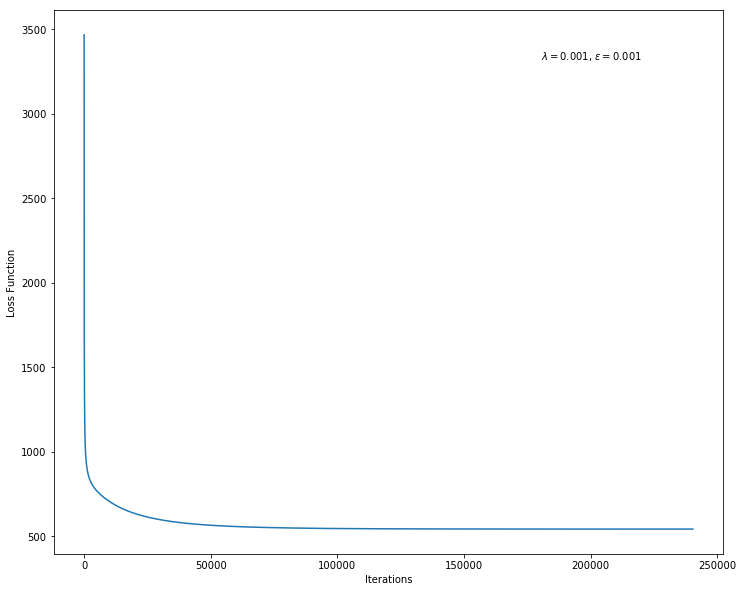

In [16]:
plot_LFvIt(Accs_batch,LvIs_batch)

Part 2
-------
Instead of batch descent, we can use the following procedure to find the optimal $w$ using stochastic gradient descent:

(1)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w \leftarrow$ arbitrary starting point  
(2)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; while $J(w) > 0$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w \leftarrow w - \epsilon(2 \lambda w - X_i^T(y_i-s_i))$  
(3)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; return $w$

Step (1) - Same as in batch gradient descent

In [17]:
w = np.zeros(len(descriptions))

Step (2) - we can reuse the functions for calculating the cost function and the looping process defined in part 1, step 2; we define a new function for the stochastic update rule

In [18]:
def update_w_stoch(w,X,y,lam,eps):
    i = np.random.choice(len(X))
    y_i = y[i]
    X_i = X[i]
    s_i = spsp.expit(np.dot(X_i,w))
    w_prime = w - eps*(2*lam*w-X_i*(y_i-s_i))
    
    return w_prime

Step (3)

Again, we try several values of hyperparameters $\lambda$ and $\epsilon$ to find the optimal values and we introduce a convergence tolerance that is used in the case that data is not linearly separable. 

In [19]:
tol = 1e-9

In [20]:
# Collect loss function as f'n of iteration number for each combo
optima_stoch = {}
LvIs_stoch = {}
for lam in lambdas:
    optima_stoch[lam]={}
    LvIs_stoch[lam]={}
    for eps in epsilons:
        print("Lambda:",lam,"\tEpsilon:",eps)
        w_star,iters,Js = whileloop(w,X,y,lam,eps,tol,update_w_stoch)
        optima_stoch[lam][eps]= w_star
        LvIs_stoch[lam][eps] = [iters,Js]
        print(iters[len(iters)-1])

Lambda: 0.001 	Epsilon: 1e-05
0:	J = 3465.7359028
500000:	J = 3364.07844802
751460
Lambda: 0.001 	Epsilon: 0.0001
0:	J = 3465.7359028
407340
Lambda: 0.001 	Epsilon: 0.001
0:	J = 3465.7359028
500000:	J = 1780.02392783
957690
Lambda: 0.01 	Epsilon: 1e-05
0:	J = 3465.7359028
500000:	J = 3368.30796372
672060
Lambda: 0.01 	Epsilon: 0.0001
0:	J = 3465.7359028
359080
Lambda: 0.01 	Epsilon: 0.001
0:	J = 3465.7359028
500000:	J = 2785.21595913
1000000:	J = 2787.32786271
1500000:	J = 2785.51122138
2000000:	J = 2785.11129489
2500000:	J = 2787.0705809
3000000:	J = 2785.28963853
3500000:	J = 2785.803959
4000000:	J = 2787.22372734
4500000:	J = 2788.00847534
5000000:	J = 2786.29573236
5500000:	J = 2785.48439103
6000000:	J = 2788.66480945
6005030
Lambda: 0.1 	Epsilon: 1e-05
0:	J = 3465.7359028
214990
Lambda: 0.1 	Epsilon: 0.0001
0:	J = 3465.7359028
500000:	J = 3365.64013098
1000000:	J = 3365.10773544
1500000:	J = 3365.41298886
2000000:	J = 3365.44933867
2500000:	J = 3365.16683129
3000000:	J = 3365.2569

Print out a list of the optimum w\* for each combination of $\lambda$ and $\epsilon$. Save the accuracies in a list.

In [21]:
Accs_stoch = HyperparameterAccs(lambdas,epsilons,optima_stoch,X_val,y_val)

lam = 0.001	eps = 1e-05 		Accuracy:  0.902
lam = 0.001	eps = 0.0001 		Accuracy:  0.903
lam = 0.001	eps = 0.001 		Accuracy:  0.913
lam = 0.01	eps = 1e-05 		Accuracy:  0.902
lam = 0.01	eps = 0.0001 		Accuracy:  0.903
lam = 0.01	eps = 0.001 		Accuracy:  0.904
lam = 0.1	eps = 1e-05 		Accuracy:  0.901
lam = 0.1	eps = 0.0001 		Accuracy:  0.901
lam = 0.1	eps = 0.001 		Accuracy:  0.9
lam = 1.0	eps = 1e-05 		Accuracy:  0.903
lam = 1.0	eps = 0.0001 		Accuracy:  0.902
lam = 1.0	eps = 0.001 		Accuracy:  0.899
lam = 10.0	eps = 1e-05 		Accuracy:  0.904
lam = 10.0	eps = 0.0001 		Accuracy:  0.889
lam = 10.0	eps = 0.001 		Accuracy:  0.893


Plot the loss function vs. iteration number for the best combination of $\lambda, \epsilon$.

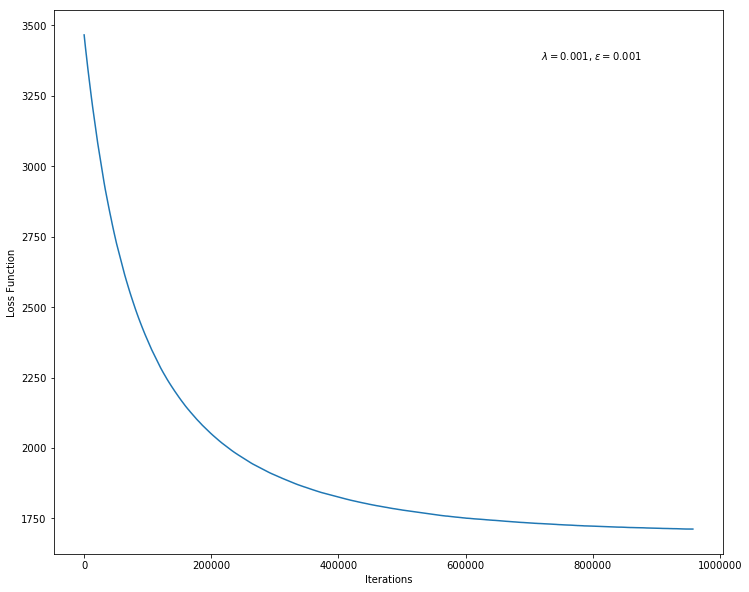

In [22]:
plot_LFvIt(Accs_stoch,LvIs_stoch)

Part 3
----------------------------
Now we wish to repeat part 2 (stochastic gradient descent) but using a variable $\epsilon$.   
We can accomplish this by redefining our while loop to decrease $\epsilon$ such that $\epsilon \propto 1/t$.

In [23]:
def whileloop_deceps(w,X,y,lam,eps,tol,update_fn):
    i=0
    iters,Js = [],[]
    J = costfnJ(w,X,y,lam)
    lastJ = J+1  #dummy condition to pass while condition on first run
    while J>0 and i<=1e7 and np.absolute(lastJ-J)>tol:
        w_prime = update_fn(w,X,y,lam,eps/(i+1))
        w = w_prime
        if i%10==0:
            if i%500000==0:
                print(str(i)+":\tJ =",str(J))
            iters.append(i)
            Js.append(J)
        lastJ = J
        J = costfnJ(w,X,y,lam)
        i+=1
        
    return w,iters,Js

Then, we call that function using the same procedure used before.

In [24]:
# Collect loss function as f'n of iteration number for each combo
optima_stoch_deceps = {}
LvIs_stoch_deceps = {}
for lam in lambdas:
    optima_stoch_deceps[lam]={}
    LvIs_stoch_deceps[lam]={}
    for eps in epsilons:
        print("Lambda:",lam,"\tEpsilon:",eps)
        w_star,iters,Js = whileloop_deceps(w,X,y,lam,eps,tol,update_w_stoch)
        optima_stoch_deceps[lam][eps]= w_star
        LvIs_stoch_deceps[lam][eps] = [iters,Js]
        print(iters[len(iters)-1])

Lambda: 0.001 	Epsilon: 1e-05
0:	J = 3465.7359028
990
Lambda: 0.001 	Epsilon: 0.0001
0:	J = 3465.7359028
1400
Lambda: 0.001 	Epsilon: 0.001
0:	J = 3465.7359028
3500
Lambda: 0.01 	Epsilon: 1e-05
0:	J = 3465.7359028
1040
Lambda: 0.01 	Epsilon: 0.0001
0:	J = 3465.7359028
1430
Lambda: 0.01 	Epsilon: 0.001
0:	J = 3465.7359028
1860
Lambda: 0.1 	Epsilon: 1e-05
0:	J = 3465.7359028
840
Lambda: 0.1 	Epsilon: 0.0001
0:	J = 3465.7359028
990
Lambda: 0.1 	Epsilon: 0.001
0:	J = 3465.7359028
23150
Lambda: 1.0 	Epsilon: 1e-05
0:	J = 3465.7359028
290
Lambda: 1.0 	Epsilon: 0.0001
0:	J = 3465.7359028
2940
Lambda: 1.0 	Epsilon: 0.001
0:	J = 3465.7359028
3020
Lambda: 10.0 	Epsilon: 1e-05
0:	J = 3465.7359028
1180
Lambda: 10.0 	Epsilon: 0.0001
0:	J = 3465.7359028
3930
Lambda: 10.0 	Epsilon: 0.001
0:	J = 3465.7359028
3880


Print out a list of the optimum w\* for each combination of $\lambda$ and $\epsilon$. Save the accuracies in a list.

In [25]:
Accs_stoch_deceps = HyperparameterAccs(lambdas,epsilons,optima_stoch_deceps,X_val,y_val)

lam = 0.001	eps = 1e-05 		Accuracy:  0.88
lam = 0.001	eps = 0.0001 		Accuracy:  0.884
lam = 0.001	eps = 0.001 		Accuracy:  0.875
lam = 0.01	eps = 1e-05 		Accuracy:  0.884
lam = 0.01	eps = 0.0001 		Accuracy:  0.769
lam = 0.01	eps = 0.001 		Accuracy:  0.854
lam = 0.1	eps = 1e-05 		Accuracy:  0.877
lam = 0.1	eps = 0.0001 		Accuracy:  0.871
lam = 0.1	eps = 0.001 		Accuracy:  0.883
lam = 1.0	eps = 1e-05 		Accuracy:  0.761
lam = 1.0	eps = 0.0001 		Accuracy:  0.874
lam = 1.0	eps = 0.001 		Accuracy:  0.869
lam = 10.0	eps = 1e-05 		Accuracy:  0.892
lam = 10.0	eps = 0.0001 		Accuracy:  0.864
lam = 10.0	eps = 0.001 		Accuracy:  0.887


Plot the loss function vs. iteration number for the best combination of $\lambda, \epsilon$.

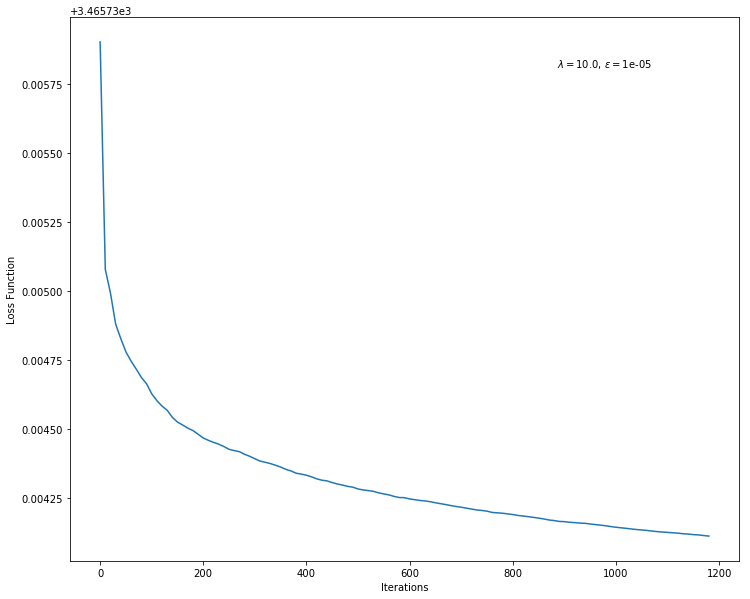

In [26]:
plot_LFvIt(Accs_stoch_deceps,LvIs_stoch_deceps)

Finally, we use our most successful training algorithm (in this case, batch gradient descent for $\lambda = 0.001$ and $\epsilon = 0.001$) to predict on the test data.

In [51]:
lam,eps = 0.001,0.001
w_star = optima_batch[lam][eps]
preds = spsp.expit(np.dot(X_test,w_star))
predictions = np.rint(preds)

We save these predictions to the csv file for Kaggle submission.

In [38]:
IDs = np.arange(len(predictions))
numpycsv = np.c_[IDs,predictions]
np.savetxt(BASE_DIR+'/'+'Prob4_testpredictions.csv',numpycsv,fmt='%i',delimiter=',',header='Id,Category',comments='')

Noting that this submission on Kaggle produced a test error of almost 12% (significantly more than the training error of 3% for the same hyperparameters), I chose a new set of hyperparameters with $\lambda$ greater than the first submission. The intention of this was to reduce overfitting, as I had presumably been overfitting, giving an excellent training error but mediocre test error. 

In [50]:
lam,eps = 0.1,0.001
w_star2 = optima_batch[lam][eps]
preds2 = spsp.expit(np.dot(X_test,w_star2))
predictions2 = np.rint(preds2)

Again, we save these predictions to the csv file for Kaggle submission.

In [45]:
IDs = np.arange(len(predictions))
numpycsv = np.c_[IDs,predictions]
np.savetxt(BASE_DIR+'/'+'Prob4_testpredictions2.csv',numpycsv,fmt='%i',delimiter=',',header='Id,Category',comments='')

The hypothesis seems accurate. This submission (username **mnegus**) gave a score of **95.565%**.